<a href="https://colab.research.google.com/github/gusthcf/ia-ufop/blob/main/Apresentacao-disciplina/Agentes-implementacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação - Smart house**

A seguir, vamos apresentar a implementação de uma possível funcionalidade de um Data Center.

Imagine que a implementação simule um agente que gerencia o uso de energia em um data center, comparando duas estratégias:
1. Média histórica simples do preço da energia.
2. Média móvel dos últimos 5 dias.


# Importar bibliotecas necessárias para executar o código


In [207]:
from random import *
import matplotlib.pyplot as plt
import numpy as np

# Definição do ambiente

Vamos armazenar no ambiente as seguintes informações:

*   Preço do produto em cada um dos dias da série
*   Histórico do estoque de energia
*   Histórico da quantidade de energia comprada
*   Histórico da quantidade de energia consumida

In [208]:
# definicao da classe ambiente
class Ambiente():

  def __init__(self):
    # Ambiente explorado pelo agente de compra de papel higienico
    self.estoque=300 # valor do estoque inicial de energia
    self.historico_preco=[1.25]
    self.historico_consumo=[]

    # media simples
    self.historico_estoque=[self.estoque]
    self.historico_qtde_comprados=[]

    # media movel
    self.historico_estoque_movel=[self.estoque]
    self.historico_qtde_comprados_movel=[]

  def percebe_preco_atual(self):
    return self.historico_preco[len(self.historico_preco)-1]

  def percebe_estoque(self):
    return self.historico_estoque[len(self.historico_estoque)-1]

  def percebe_estoque_movel(self):
    return self.historico_estoque_movel[len(self.historico_estoque_movel)-1]

  def run(self, dic_acoes):
    '''realizar alteracoes no ambiente:
       Definir, aleatoriamente, uma quantidade de energia consumida
       Atualizar o historico do estoque e preço atual
       Essas informacoes serao utilizadas pelo agente para decidir a compra ou nao de energia
    '''
    # gerando o consumo realizado aleatoriamente e o colocando no historico de consumo
    qtde_consumidos = randint(200,400) # recebe aleatoriamente valores entre 200 e 400 [start, end] - Intervalo fechado
    self.historico_consumo.append(qtde_consumidos)

    # atualizando o estoque e a quantidade a ser comprada para media simples
    consumo_bateria = dic_acoes["comprar"] - qtde_consumidos
    estoque_atual = self.historico_estoque[len(self.historico_estoque)-1] + consumo_bateria
    if estoque_atual > 500:
      estoque_atual = 500
    self.historico_estoque.append(estoque_atual)
    self.historico_qtde_comprados.append(dic_acoes["comprar"])

    # atualizando o estoque e a quantidade a ser comprada para media movel
    consumo_bateria_movel = dic_acoes["comprar_movel"] - qtde_consumidos
    estoque_atual_movel = self.historico_estoque_movel[len(self.historico_estoque_movel)-1] + consumo_bateria_movel
    if estoque_atual_movel > 500:
      estoque_atual_movel = 500
    self.historico_estoque_movel.append(estoque_atual_movel)
    self.historico_qtde_comprados_movel.append(dic_acoes["comprar_movel"])

    # atualizando o preço para o proximo dia
    valor = 0.5 + 1.5 * random() # novo valor do produto. random() gera valores entre [0,1]
    self.historico_preco.append(valor)

# Definição do agente

O agente vai armazenar informações sobre:

*   Ambiente (Composição de classes)
*   Valor médio dos últimos preços do produto
*   Informação sobre o estoque atual de energia no DataCenter

In [209]:
# Definição da classe agente

class Agente():

  def __init__(self, ambiente):
    self.num_dias = 1
    self.ambiente= ambiente
    self.estoque= ambiente.percebe_estoque()
    self.estoque_movel= ambiente.percebe_estoque()
    self.total_gasto = self.total_gasto_movel = 0
    self.preco_atual = self.media = self.media_movel = ambiente.percebe_preco_atual()

  def executa_agente(self, qtde_dias):

    for i in range(qtde_dias):
      # O agente percebe o estado do ambiente
      self.estoque= self.ambiente.percebe_estoque()
      self.estoque_movel= self.ambiente.percebe_estoque_movel()
      self.preco_atual= self.ambiente.percebe_preco_atual()
      estoque_projetado = self.estoque - 300

      '''
        Controlador do agente:
        - Define a regra para compra de energia:
      '''

      # media simples
      if self.estoque <= 0:
        break
      elif self.preco_atual > self.media:
        compra = 600 - self.estoque
        if compra > 400:
          compra = 400
      elif self.preco_atual <= self.media:
        compra = 700 - self.estoque
        if compra > 400:
          compra = 400

      # media movel com janela = 5
      if self.estoque_movel <= 0:
        break
      elif self.preco_atual > self.media_movel:
        compra_movel = 600 - self.estoque_movel
        if compra_movel > 400:
          compra_movel = 400
      elif self.preco_atual <= self.media_movel:
        compra_movel = 700 - self.estoque_movel
        if compra_movel > 400:
          compra_movel = 400

      # Fim do controlador
      self.total_gasto += self.preco_atual*compra
      self.total_gasto_movel += self.preco_atual*compra_movel
      # O agente aplica modificacoes ao ambiente)
      self.ambiente.run({"comprar": compra, "comprar_movel": compra_movel})

      self.num_dias+=1
      self.media = (self.media*(self.num_dias-1) + self.preco_atual)/self.num_dias
      if len(self.ambiente.historico_preco) < 5:
        self.media_movel = self.media
      else:
        self.media_movel = np.mean(self.ambiente.historico_preco[-5:])

# Definir classe para impressão dos resultados


In [210]:
class Imprime():
  def imprime_resultado(agente):
    historico_dias = np.linspace(0, agente.num_dias-1, agente.num_dias-1)
    historico_dias_estoque = np.linspace(0, agente.num_dias, agente.num_dias) # o estoque precisa ter 1 dia a mais


    # primeira impressão: historico do preco
    agente.ambiente.historico_preco.pop() # removendo o ultimo preco da lista, ja que ele nao vai ser utilizado
    plt.figure(figsize=(10, 4))
    plt.plot(historico_dias, agente.ambiente.historico_preco, 'bo-', label='Preço')
    plt.title('Histórico de Preços')
    plt.xlabel('Dia')
    plt.ylabel('Preço (R$)')
    plt.legend()
    plt.show()


    # segunda impressão: historico do consumo
    plt.figure(figsize=(10, 4))
    plt.plot(historico_dias,agente.ambiente.historico_consumo , 'ms-', label='Consumo')
    plt.title('Histórico de Consumo')
    plt.xlabel('Dia')
    plt.ylabel('Consumo (kWh)')
    plt.legend()
    plt.show()

    # Segunda impressão: historico do estoque
    plt.figure(figsize=(10, 4))
    plt.plot(historico_dias_estoque, agente.ambiente.historico_estoque, 'r--', label='Média simples')
    plt.plot(historico_dias_estoque, agente.ambiente.historico_estoque_movel, 'b--', label='Média movel')
    plt.axhline(y=200, color='black', linestyle='--', linewidth=1.5, label='Nível crítico')
    plt.ylim(100, 500)
    plt.title('Histórico do estoque')
    plt.xlabel('Dia')
    plt.ylabel('Estoque (kWh)')
    plt.legend()
    plt.show()


    print(f'Custo media simples: {agente.total_gasto}')
    print(f'Custo media movel: {agente.total_gasto_movel}')


# Execução do programa

Por um determinado número de iterações, vamos gerar valores aleatórios para o preco da energia e para a quantidade de energia consumida.

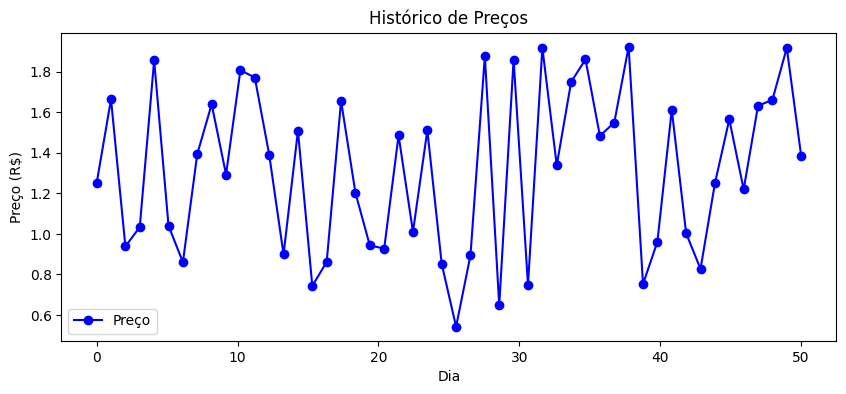

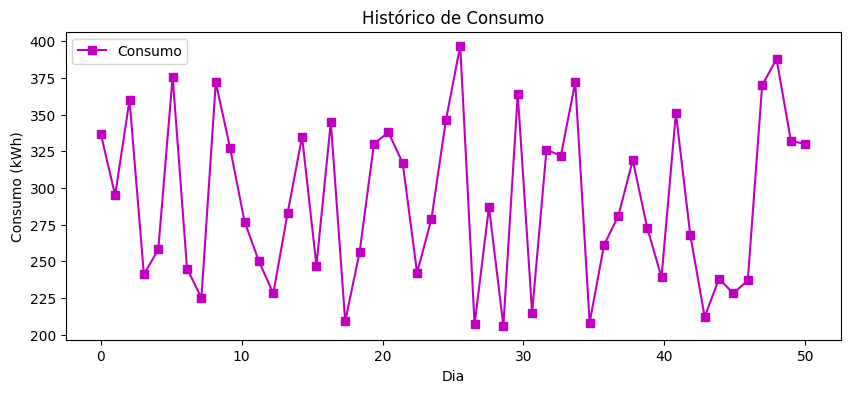

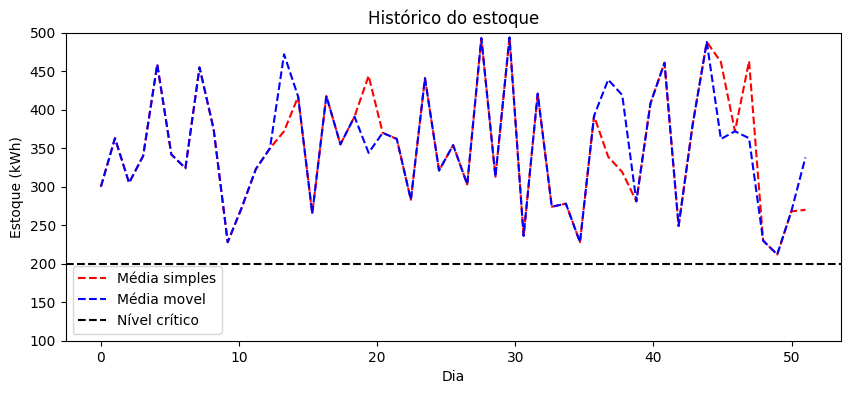

Custo media simples: 18009.25498847191
Custo media movel: 18155.51576511093


In [215]:
ambiente_atuacao = Ambiente()
smart_house = Agente(ambiente_atuacao)
smart_house.executa_agente(50)


Imprime.imprime_resultado(smart_house)